In [303]:
%load_ext autoreload

%autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
import sys
!{sys.executable} -m pip install ants

Defaulting to user installation because normal site-packages is not writeable
  Using cached ants-0.0.7.tar.gz (10 kB)
  Preparing metadata (setup.py) ... done
  Using cached Django-5.0.6-py3-none-any.whl (8.2 MB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.5/6.5 MB 52.3 MB/s eta 0:00:00m eta 0:00:010:0101
  Using cached sqlparse-0.5.0-py3-none-any.whl (43 kB)
  Using cached asgiref-3.8.1-py3-none-any.whl (23 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 616.0/616.0 KB 69.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 247.8/247.8 KB 18.3 MB/s eta 0:00:00
  Using cached zope.event-5.0-py3-none-any.whl (6.8 kB)
  Created wheel for ants: filename=ants-0.0.7-py3-none-any.whl size=14539 sha256=e87e8d7bc3a61f9e4a65a0a75517627322f09a632019f35d8663daf7c70477c0
  Stored in directory: /home/zeynepboztoprak/.cache/pip/wheels/2d/36/ad/719ec3c226c5547a8ed5a668a5fc95cf01919db0453dc220ca
Successfully built ants


In [301]:
from utils2 import load_images, to_itk

In [300]:
import json
import sys
import torch

import matplotlib.patches as patches
import cv2
import json
import h5py
import numpy as np
import SimpleITK as sitk
import numpy as np
import ipywidgets as widgets
from IPython.display import display, clear_output
from PIL import Image, ImageOps
import matplotlib.pyplot as plt
import torchvision

from torchvision.models.detection import maskrcnn_resnet50_fpn
from torchvision.models.detection import maskrcnn_resnet50_fpn

# custom
from utils import blend_images, normalize_pixel_values, convert_to, plot_two_imgs, resize_img, rgb_to_grayscale, select_appropriate_pyramid_level, rescale_img, pad_img, rotate_image
from ants_registration import ants_registration, plot_images

In [295]:
TRANS_PYRAMID_LEVEL = "04"
(bf_img, bf_mask_img), (trans_img, trans_mask_img) = load_images(bf_pyramid_level=None, trans_pyramid_level=TRANS_PYRAMID_LEVEL)

In [296]:
bf_img = rgb_to_grayscale(bf_img)
bf_img.shape

(3648, 5472)

In [270]:
for k in bf_fd['pyramid'].keys():
    print(k, trans_fd['pyramid'][k].shape)

00 (68783, 99469)
01 (34392, 49735)
02 (17196, 24868)
03 (8598, 12434)
04 (4299, 6217)
05 (2150, 3109)
06 (1075, 1555)
07 (538, 778)
08 (269, 389)
09 (135, 195)
10 (68, 98)
11 (34, 49)
12 (17, 25)
13 (9, 13)


In [297]:
trans_img.shape, trans_mask_img.shape

((4299, 6217), (4299, 6219))

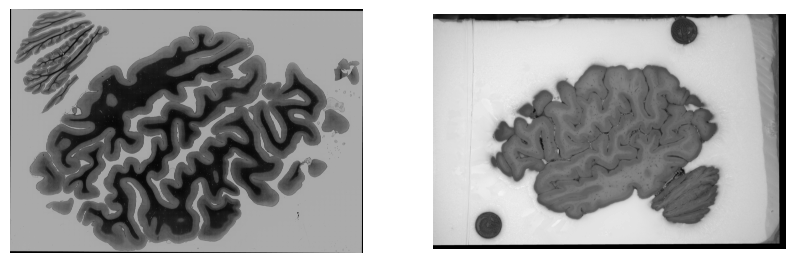

(4299, 6217) (4299, 6219)


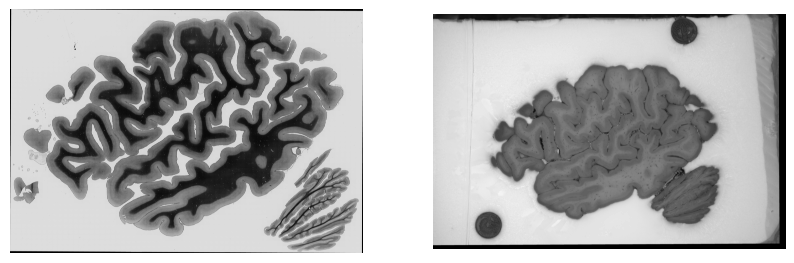

In [298]:
plot_two_imgs(trans_img, bf_img)

rotated_trans_img = rotate_image(trans_img, 180)
rotated_trans_mask_img = rotate_image(trans_mask_img, 180)

print(rotated_trans_img.shape, rotated_trans_mask_img.shape)

plot_two_imgs(rotated_trans_img, bf_img)

In [304]:
sitk_trans_img = to_itk(rotated_trans_img, (2**int(TRANS_PYRAMID_LEVEL) * 1.33))
sitk_trans_mask_img = to_itk(rotated_trans_mask_img, (2**int(TRANS_PYRAMID_LEVEL) * 1.33))

if bf_pyramid_level is None:
    bf_pyramid_level = 0
sitk_bf_img = to_itk(bf_img, (2**bf_pyramid_level *bf_fd['Image'].attrs['pixel_width']))
sitk_bf_mask_img = to_itk(bf_mask_img, (2**bf_pyramid_level * bf_fd['Image'].attrs['pixel_width']))

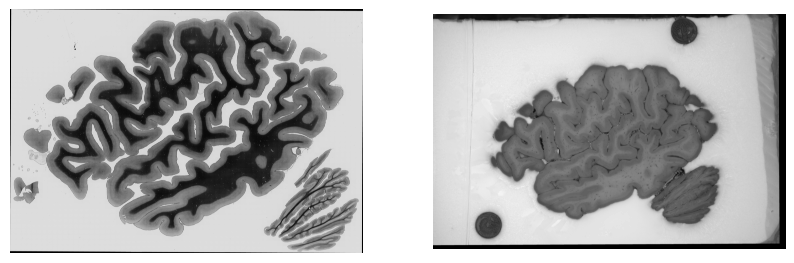

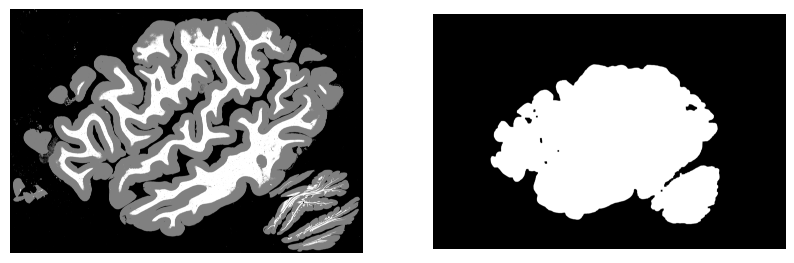

In [305]:
## test

a1 = sitk.GetArrayFromImage(sitk_trans_img)
a2 = sitk.GetArrayFromImage(sitk_trans_mask_img)

b1 = sitk.GetArrayFromImage(sitk_bf_img)
b2 = sitk.GetArrayFromImage(sitk_bf_mask_img)

plot_two_imgs(a1, b1)
plot_two_imgs(a2, b2)

In [306]:
a1.shape, a2.shape

((4299, 6217), (4299, 6219))

In [307]:
scaling_factor = (2**int(TRANS_PYRAMID_LEVEL) * 1.33) / bf_fd['Image'].attrs['pixel_width']

(2842, 4110) (2842, 4111)


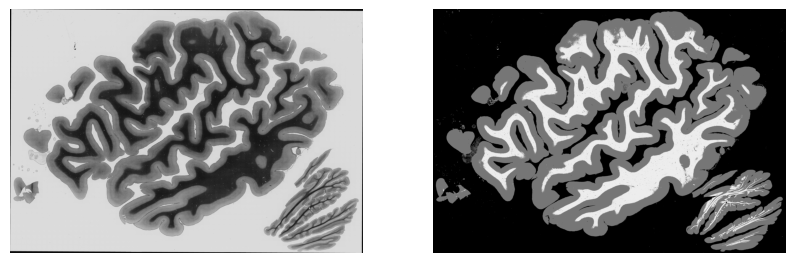

In [308]:
scaled_trans_img = cv2.resize(rotated_trans_img, (0, 0), fx=scaling_factor, fy=scaling_factor, interpolation=cv2.INTER_CUBIC)
scaled_trans_mask_img = cv2.resize(rotated_trans_mask_img, (0, 0), fx=scaling_factor, fy=scaling_factor, interpolation=cv2.INTER_CUBIC)

print(scaled_trans_img.shape, scaled_mask_trans_img.shape)

plot_two_imgs(scaled_trans_img, scaled_mask_trans_img)

In [309]:
rotated_trans_img.shape, rotated_trans_mask_img.shape, scaled_trans_img.shape, scaled_trans_mask_img.shape

((4299, 6217), (4299, 6219), (2842, 4110), (2842, 4111))

In [213]:
bf_mask_img.shape, trans_mask_img.shape

((3648, 5472), (4299, 6219))

In [216]:
registered_moving_mask = register_masks(sitk_bf_mask_img, sitk_trans_mask_img)

(6219, 4299)
(6219, 4299)


In [219]:
registered_moving_mask_np = sitk.GetArrayFromImage(registered_moving_mask)

In [220]:
bf_mask_img.shape, registered_moving_mask_np.shape

((3648, 5472), (4299, 6219))

In [ ]:
transformed_trans_image = cv2.resize(rotated_trans_img, (0, 0), fx=scaling_factor, fy=scaling_factor, interpolation=cv2.INTER_CUBIC)